# ELMo를 통한 문장분류(Text Classfication)

- **코드출처** :https://github.com/strongio/keras-elmo/blob/master/Elmo%20Keras.ipynb
- **IMDB movie review 데이터 셋을 이용한 감성분석 문장 분류**  
리뷰 문장이 긍정적(positive)인지 혹은 부정적(negative)인지를 예측하는 문장 분류  task
- **텐서플로우 허브를 이용한 Pre-trained ELMo를 다운로드 하여 사용**  
ELMo의 가장 큰 특징은 사전 훈련된 언어 모델(Pre-trained language model)을 사용한다는 점으로 이는 ELMo의 이름에 LM이 들어간 이유입니다. 텐서플로우 허브(TensorFlow Hub)는 일반화된 문제들에 대해서 모델의 재사용성을 극대화하기 위해서 구글에서 공개한 API로 텐서플로우 1.7.0 버전 이상에서 사용할 수 있고 명령어를 통해 TensorFlow Hub 라이브러리를 설치해주어야 합니다.

- 참고 - 한국어 ELMo :   
https://github.com/HIT-SCIR/ELMoForManyLangs  
https://ratsgo.github.io/embedding/
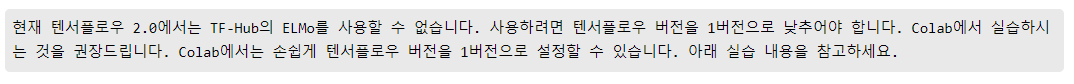참고자료 : https://wikidocs.net/33930

이번 실습은 colab에서 수행한다고 가정하에, 우선 텐서플로우 버전을 1.x로 설정하겠습니다 !

In [1]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [2]:
pip install tensorflow-hub

## Import library

In [3]:
# 필요한 라이브러리 import
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import numpy as np

# 기존 tensorflow 에서 세션을 만듭니다. 그리고 그것을 keras에 등록시켜 keras가 해당 세션을 사용할 수 있도록 합니다. 
# (tensorflow2.X에선 필요없는 과정..)
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


## Data

In [4]:
# 디렉토리 안에 있는 모든 파일들을 DataFrame 형태로 읽어오는 함수
def load_directory_data(directory):
  data = {}  # 구체적으로 문장과 문장의 감정상태의 확신정도(sentiment=1~10)를 읽어옵니다.
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read()) #파일의 내용 전체를 문자열로
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# 긍정(positive)예제와 부정(negative) 예제를 하나의 dataframe으로 합치고
# 긍정 혹은 부정을 나타내는 polarity 칼럼을 추가하고 데이터를 랜덤하게 섞습니다.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# IMDB 영화 리뷰 데이터셋을 다운
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

# 로깅 레벨을 ERROR로 설정합니다.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

84131840/84125825 [==============================] - 9s 0us/step


,sentence,sentiment,polarity
0,Jean Harlow and Clark Gable were a great on sc...,8,1
1,i almost did not go see this movie because i r...,9,1
2,"Hugh (Ed Harris) is a hotshot, bachelor senato...",7,1
3,This incredibly overrated anime television ser...,1,0
4,"College students, who are clearing out a conde...",4,0


In [5]:
# 데이터셋 생성, 글자수는 150개 까지
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:150]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:150]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()

In [6]:
train_text

array([["Jean Harlow and Clark Gable were a great on screen team and this may be their best movie together.<br /><br />Yes, Hold Your Man can be cheesy and predictable, but that's not what I love about the movie. I love seeing Harlow and Gable together and in this film they are simply wonderful. It is obvious that they really enjoyed working together and that is part of what makes this such a wonderful film.<br /><br />The witty dialogue, great script and attention to detail are the other things that make this such a good movie. I loved this movie the first time I saw it and on each subsequent viewing I always notice at least one new detail. To me, that is a mark of a great film.<br /><br />The dialogue and script are better than most movies from this time period (early 30's). I adore classic movies, but I"],
       ["i almost did not go see this movie because i remember march of the penguin was not that much exciting. I went mainly because Disney promised to plant a tree if i go see i

## ELMO embedding

In [7]:
# 가중치를 업데이트 할 수 있는 커스텀 레이어를 만듭니다.
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))
        self.trainable_weights += tf.trainable_variables(scope="^{}_module/.*".format(self.name)) #elmo 적용시키며 가중치 계산하고 업데이트 
        super(ElmoEmbeddingLayer, self).build(input_shape)  # super()로 기반 클래스의 build 메서드 호출

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default', # ELMo는 텐서플로우 허브로부터 가져온 것이기 때문에 케라스에서 사용하기 위해서는 케라스에서 사용할 수 있도록 변환해주는 작업들이 필요합니다.
                      )['default'] # 데이터의 이동이 케라스 → 텐서플로우 → 케라스가 되도록 하는 함수
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape): 
        return (input_shape[0], self.dimensions)

## Build model

In [8]:
# 모델 설계
def build_model(): 
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  dense = layers.Dense(256, activation='relu')(embedding)
  pred = layers.Dense(1, activation='sigmoid')(dense)

  model = Model(inputs=[input_text], outputs=pred)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  
  return model

In [12]:
# 모델 적용
model = build_model()
model.fit(train_text, 
          train_label,
          validation_data=(test_text, test_label),
          epochs=5,
          batch_size=32)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_2 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 262,661
Trainable params: 262,661
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 740s 30ms/step - loss: 0.4553 - accuracy: 0.7825 - val_loss: 0.4184 - val_accuracy: 0.8080
Epoch 2/5
25000/25000 [==============================

In [13]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(test_text, test_label)[1]))

25000/25000 [==============================] - 372s 15ms/step

 테스트 정확도: 0.8260


# 마치며..

지금은 Bert에 밀려 인기도 없고.. 코드자료도 많이 없고... 하지만    
ELMo는 방대한 텍스트 데이터를 (사전) 훈련받은 대규모 언어 모델이 다양한 NLU 과제에서 최고의 성능을 낼 수 있음을 최초로 증명했다는 점,   
비교적 오래 전에 등장한 Bi-LSTM을 통해서 우수한 Pre-trained language model을 만들었다는 점에서 ELMo를 눈여겨 볼 만합니다!